In [1]:
import numpy as np
import rasterio # must be version >1. (using 1.09)
import pandas as pd
import matplotlib.pyplot as plt
import os as os
%matplotlib inline

In [2]:
# bilinear interpolation
def bilint(z,en):
    """
    https://en.wikipedia.org/wiki/Bilinear_interpolation for a unit square
    """
    r = en[1]
    c = en[0]
    ir = np.int(r)
    ic = np.int(c)
    rx = r-ir
    cy = c-ic
    #print(r,ir,rx,'  ',c,ic,cy)
    #print(z[ir,ic],z[ir+1,ic])
    #print(z[ir+1,ic],z[ir+1,ic+1])
    zi = z[ir,ic]*(1.-cy)*(1.-rx)+z[ir+1,ic]*cy*(1.-rx)+z[ir,ic+1]*(1.-cy)*rx+z[ir+1,ic+1]*rx*cy
    return zi


0
D:\crs\proj\2015_Sandwich\2017_Karen_Sandwich_maps\2016-01-22_SandwichTNB_PT_DEM_10cm_trimmed.tif
2016-01-22_SandwichTNB
Trying to read  D:\crs\proj\2015_Sandwich\2017_Karen_Sandwich_maps\trans\2016-01-22_SandwichTNB_trans.txt
2016-01-22_SandwichTNB_trans.txt  has  65 lines.
Read:  64  lines.
Reading D:\crs\proj\2015_Sandwich\2017_Karen_Sandwich_maps\2016-01-22_SandwichTNB_PT_DEM_10cm_trimmed.tif...
DEM shape:  (10226, 11987)
rasterio gdal version:  2.2.0

| 0.10, 0.00, 376286.64|
| 0.00,-0.10, 4625440.83|
| 0.00, 0.00, 1.00|
upper left:  (376286.64299908397, 4625440.8344103005)
lower right:  (377485.3429990839, 4624418.234410301)

Statistics for interpolated values:
count    64.000000
mean     -0.004697
std       0.061948
min      -0.162035
25%      -0.041626
50%      -0.012092
75%       0.022680
max       0.153820
Name: DEM_minus_trans (m), dtype: float64

Saving to D:\crs\proj\2015_Sandwich\2017_Karen_Sandwich_maps\trans_diff\2016-01-22_SandwichTNB.txt
1
D:\crs\proj\2015_Sandwich\

DEM shape:  (11815, 12142)
rasterio gdal version:  2.2.0

| 0.10, 0.00, 376239.69|
| 0.00,-0.10, 4625495.90|
| 0.00, 0.00, 1.00|
upper left:  (376239.69199030724, 4625495.902980729)
lower right:  (377453.8919903072, 4624314.402980729)

Statistics for interpolated values:
count    37.000000
mean     -0.086806
std       0.090173
min      -0.328431
25%      -0.108843
50%      -0.073331
75%      -0.042167
max       0.092915
Name: DEM_minus_trans (m), dtype: float64

Saving to D:\crs\proj\2015_Sandwich\2017_Karen_Sandwich_maps\trans_diff\2017-05-04_SandwichTNB.txt
9
D:\crs\proj\2015_Sandwich\2017_Karen_Sandwich_maps\2017-09-18_SandwichTNB_DEM_10cm_trimmed.tif
2017-09-18_SandwichTNB
Trying to read  D:\crs\proj\2015_Sandwich\2017_Karen_Sandwich_maps\trans\2017-09-18_SandwichTNB_trans.txt
2017-09-18_SandwichTNB_trans.txt  has  259 lines.
Read:  258  lines.
Reading D:\crs\proj\2015_Sandwich\2017_Karen_Sandwich_maps\2017-09-18_SandwichTNB_DEM_10cm_trimmed.tif...
DEM shape:  (10236, 11762)
raster

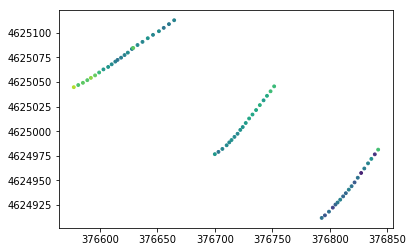

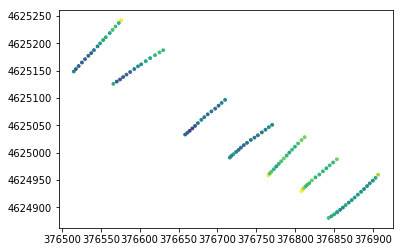

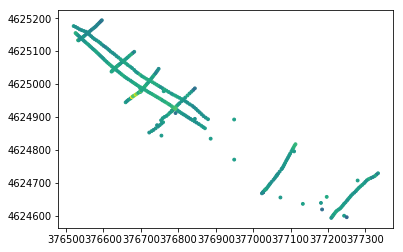

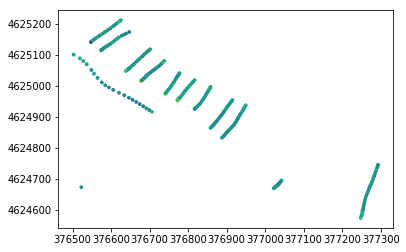

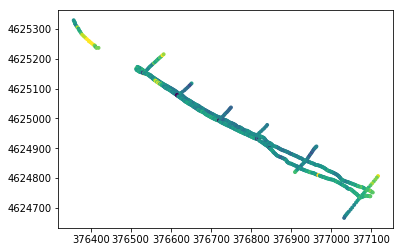

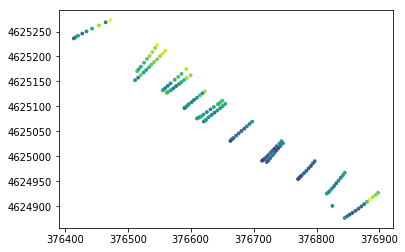

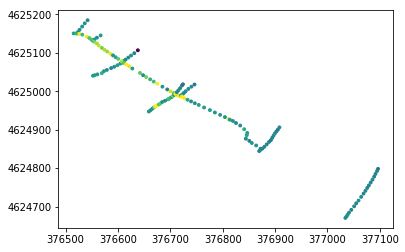

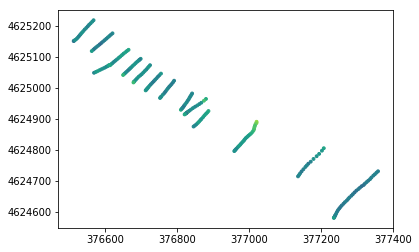

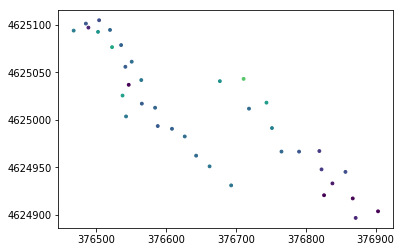

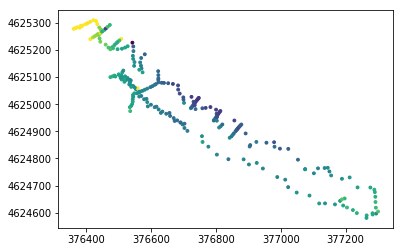

In [14]:
# list of files to read
fdir = "D:\\crs\\proj\\2015_Sandwich\\2017_Karen_Sandwich_maps\\"
fnames = (\
"2016-01-22_SandwichTNB_PT_DEM_10cm_trimmed.tif",\
"2016-02-11_SandwichTNB_DEM_10cm_trimmed.tif",\
"2016-03-30_SandwichTNB_AS_DEM_10cm_trimmed.tif",\
"2016-09-21_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-01-09_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-01-25_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-02-14_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-03-16_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-05-04_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-09-18_SandwichTNB_DEM_10cm_trimmed.tif")
# list of dates for use as titles / column headers
titles = ([\
         "22-Jan-2016",\
         "11-Feb-2016",\
         "30-Mar-2016",\
         "21-Sep-2016",\
         "09-Jan-2017",\
         "25-Jan-2017",\
         "14-Feb-2017",\
         "16-Mar-2017",\
         "04-May_2017",\
         "18-Sep-2017"])

survey_dates = ["2016-01-22","2016-02-11","2016-03-30","2016-09-21",\
                "2017-01-09","2017-01-25","2017-02-14","2017-03-16","2017-05-04","2017-09-18"]

outdir = fdir+"trans_diff\\"
nf = len(fnames)
for i in range(nf):
    print(i)
    print(fdir+fnames[i])

    bname = survey_dates[i]+"_SandwichTNB"
    print(bname)

    tname = bname+"_trans.txt"
    fn = fdir+"trans\\"+tname
    print("Trying to read ",fn)
    try:
        f=open(fn,'r')
    except OSError:
        print(tname+" is missing.")
    else:
        print(tname," has ",len(f.readlines()),"lines.")
        
    # read in the transect points
    df=pd.read_csv(fdir+"trans\\"+tname, header = 0, skiprows=0, delimiter=',')
    print("Read: ",len(df.index),' lines.')
    df
    
    # read DEM channel 1
    print("Reading "+fdir+fnames[i]+"...")
    with rasterio.open(fdir+fnames[i]) as dem:
        z = dem.read(1)
    print("DEM shape: ",np.shape(z))
    
    # The transform uses rasterio 
    print("rasterio gdal version: ",rasterio.gdal_version())
    # coordinate reference system
    print(dem.crs)
    # data transform
    print(dem.transform)
    # upper left corner
    print('upper left: ',dem.transform*(0,0))
    # lower right corner
    print('lower right: ',dem.transform*(dem.width, dem.height))
    
    # arrays for DEM and differences calcs
    zdem = np.NaN*np.ones(len(df.index))
    zdem_minus_meas = np.NaN*np.ones(len(df.index))
    
    for index, row in df.iterrows():
        # en = ~dem.transform*(row["# X/Easting (m)"],row["Y/Northing (m)"])
        en = ~dem.transform*(row["#X/Easting (m NAD83(2011) Zone 19N)"],row["Y/Northing (m NAD83(2011) Zone 19N)"])
        #print( index, en )

        # bilinear interpolation in DEM
        try:
            zdem[index]=bilint(z,en)
        except:
            print("interpolation problem")

        # No data values for DEM are -32767
        if(zdem[index]<-32000.):
            zdem[index]=np.NaN           

        zdem_minus_meas[index] = zdem[index]-row["Z/Elevation (m NAVD88)"]
        #print( zdem[index], zdi[index], row["elev"], zdem_minus_meas[index]  )

    # add columns to the dataframe
    #df.assign(DEM2=pd.Series(zdem,index=df.index))
    df['DEM (interp m)']=pd.Series(zdem,index=df.index)
    
    df['DEM_minus_trans (m)']=pd.Series(zdem_minus_meas,index=df.index)
    
    #TODO - remove outliers and calculate RMS   
    
    
    print("\nStatistics for interpolated values:")
    print(df['DEM_minus_trans (m)'].describe())
    
    print("\nSaving to "+outdir+bname+".txt")
    df.to_csv(outdir+bname+'.txt',na_rep='nan',sep=',',float_format='% 12.4f')
    
    # make map of differences
    dz = df['DEM_minus_trans (m)'].as_matrix()
    x = df['#X/Easting (m NAD83(2011) Zone 19N)'].as_matrix()
    y = df['Y/Northing (m NAD83(2011) Zone 19N)'].as_matrix()
    fig2 = plt.figure()
    plt.plot(figsize=(12,6))
    #plt.imshow(z[::],cmap=plt.cm.gray,vmin=-2,vmax=13)
    plt.scatter(x,y,8,dz,vmin=-.2,vmax=.2)
    fig_name = outdir+survey_dates[i]+"_DEM_minus_transect_MAP.png"
    fig2.savefig(fig_name,dpi=200)